In [135]:
from pyspark.sql import SparkSession, Row
from pyspark.sql import functions as F
from pyspark.sql import types as T
import geopandas as gpd
from PIL import Image
import pandas as pd
import numpy as np

In [136]:
spark = SparkSession.builder.appName('AcidSoils').getOrCreate()

In [137]:
source = gpd.read_file("data/GTK_ASsoil_obs.csv")
source.head(4)

,POINT_X,POINT_Y,CLASS,geometry
0,441468.7125,7184281.005,ASS,None
1,441852.3101,7186002.327,ASS,None
2,442236.5012,7185249.359,ASS,None
3,420520.3581,7208257.978,ASS,None


In [138]:
geom = gpd.points_from_xy(source.POINT_X.astype("float"), source.POINT_Y.astype("float"))
points = gpd.GeoDataFrame(source.CLASS, crs="EPSG:3067", geometry=geom).to_crs("WGS84")
points.head(4)

,CLASS,geometry
0,ASS,POINT (25.76894 64.77799)
1,ASS,POINT (25.77630 64.79350)
2,ASS,POINT (25.78469 64.78681)
3,ASS,POINT (25.31512 64.98873)


In [139]:
points["x"] = points.geometry.x
points["y"] = points.geometry.y
points.head(4)

,CLASS,geometry,x,y
0,ASS,POINT (25.76894 64.77799),25.768938,64.777988
1,ASS,POINT (25.77630 64.79350),25.776304,64.793496
2,ASS,POINT (25.78469 64.78681),25.784691,64.786808
3,ASS,POINT (25.31512 64.98873),25.315115,64.988732


In [140]:
df = spark.createDataFrame(points)
df.show(4,False)

+-----+---------------------------+------------------+-----------------+
|CLASS|geometry                   |x                 |y                |
+-----+---------------------------+------------------+-----------------+
|ASS  |{105553149400992, false, 2}|25.768937832725747|64.77798766173387|
|ASS  |{105553149399552, false, 2}|25.77630416654702 |64.79349633623737|
|ASS  |{105553149400224, false, 2}|25.784691167397362|64.7868078298281 |
|ASS  |{105553149399744, false, 2}|25.315115332474953|64.98873249710591|
+-----+---------------------------+------------------+-----------------+
only showing top 4 rows



## Add point ID

In [141]:
TILE_SIZE = 256
ZOOM = 9

@F.udf(returnType=T.ArrayType(T.IntegerType()))
def project_pixel(lon, lat, zoom=ZOOM):
    # lon, lat = p.geometry.x, p.geometry.y
    
    siny = np.sin(lat * np.pi / 180)
    siny = min(max(siny, -0.9999), 0.9999)
    
    x = TILE_SIZE * (0.5 + lon / 360)
    y = TILE_SIZE * (0.5 - np.log((1 + siny) / (1 - siny)) / (4 * np.pi))
    
    scale = 2**zoom

    tx = x * scale // TILE_SIZE
    ty = y * scale // TILE_SIZE

    px = x * scale % TILE_SIZE // 1
    py = y * scale % TILE_SIZE // 1

    return [int(px), int(py)]
    
    
@F.udf(returnType=T.ArrayType(T.IntegerType()))
def project_tile(lon, lat, zoom=ZOOM):
    # lon, lat = p.geometry.x, p.geometry.y
    
    siny = np.sin(lat * np.pi / 180)
    siny = min(max(siny, -0.9999), 0.9999)
    
    x = TILE_SIZE * (0.5 + lon / 360)
    y = TILE_SIZE * (0.5 - np.log((1 + siny) / (1 - siny)) / (4 * np.pi))
    
    scale = 2**zoom

    tx = x * scale // TILE_SIZE
    ty = y * scale // TILE_SIZE

    px = x * scale % TILE_SIZE // 1
    py = y * scale % TILE_SIZE // 1

    return [int(zoom), int(tx), int(ty)]

In [142]:
df_points = (
    df
    .withColumn("pixel", project_pixel(df.x, df.y))
    .withColumn("tile", project_tile(df.x, df.y))
    .withColumn("point_id", F.monotonically_increasing_id())
    .drop("geometry")
)

df_points.show(4)


+-----+------------------+-----------------+----------+-------------+--------+
|CLASS|                 x|                y|     pixel|         tile|point_id|
+-----+------------------+-----------------+----------+-------------+--------+
|  ASS|25.768937832725747|64.77798766173387|[166, 252]|[9, 292, 133]|       0|
|  ASS| 25.77630416654702|64.79349633623737|[168, 239]|[9, 292, 133]|       1|
|  ASS|25.784691167397362| 64.7868078298281|[171, 245]|[9, 292, 133]|       2|
|  ASS|25.315115332474953|64.98873249710591|   [0, 71]|[9, 292, 133]|       3|
+-----+------------------+-----------------+----------+-------------+--------+
only showing top 4 rows



## pixel coordinates

In [143]:
TILES_BASIC = "/Users/tamiratatsemegiorgis/project/MapTilesViewer/basic/{z}/{x}/{y}.png"
TILES_HILLSHADE ="/Users/tamiratatsemegiorgis/project/TILES_hillshade/{z}/{x}/{y}.png"

@F.udf(returnType=T.ArrayType(T.ArrayType(T.LongType())))
def load_image_data(tile, pixel_data, tiles):
    """
    tiles: folder with tiles
    """
    (z, tx, ty) = tile
    fname = tiles.format(z=z, x=tx, y=ty)
    im = Image.open(fname)
    arr_img= np.array(im)

    data = []
    for i, j, pid in pixel_data:
        if arr_img.shape[-1] == 3:
            # color image
            r, g, b = arr_img[i, j] # 3 dim array, ?
            data.append([int(r), int(g), int(b), pid])
        else:
            # grayscale image
            gray, alpha = arr_img[i, j]
            data.append([int(gray), pid])
    
    return data


In [144]:
df_basic_raw = (
    df_points
    .select(
        "point_id", 
        "pixel", 
        "tile"
    )
    .withColumn("pixel_i", F.col("pixel")[0])
    .withColumn("pixel_j", F.col("pixel")[1])
    .withColumn("pixel_data", F.array(F.col("pixel_i"), F.col("pixel_j"), F.col("point_id")))

    # processing
    .groupby("tile")
    .agg(
        F.collect_list("pixel_data").alias("pixel_data_list"),
    )
    .withColumn("data_basic", load_image_data(F.col("tile"), F.col("pixel_data_list"), F.lit(TILES_BASIC)))
    
)

df_basic_raw.show(4)

+-------------+--------------------+--------------------+
|         tile|     pixel_data_list|          data_basic|
+-------------+--------------------+--------------------+
|[9, 288, 136]|[[250, 244, 459],...|[[75, 86, 56, 459...|
|[9, 293, 132]|[[6, 2, 108], [4,...|[[127, 142, 109, ...|
|[9, 292, 131]|[[176, 223, 98], ...|[[111, 118, 85, 9...|
|[9, 289, 136]|[[164, 93, 393], ...|[[93, 104, 74, 39...|
+-------------+--------------------+--------------------+
only showing top 4 rows



In [202]:
df_basic = (
    df_basic_raw
    .select(F.explode("data_basic").alias("data"))
    .select(
        F.col("data")[0].alias("basic_r"),
        F.col("data")[1].alias("basic_g"),
        F.col("data")[2].alias("basic_b"),
        F.col("data")[3].alias("point_id"),
    )
    
    # put back points class
    .join(
        df_points.select("CLASS", "point_id"),
        on="point_id",
    
    )
    .withColumn("CLASS", (F.col("CLASS") == "ASS").astype("int").alias("class"),)
    
    
)

df_basic.show(4)

+--------+-------+-------+-------+-----+
|point_id|basic_r|basic_g|basic_b|CLASS|
+--------+-------+-------+-------+-----+
|      26|    118|    111|     95|    1|
|      29|    107|    102|     82|    1|
|     474|     53|     75|     39|    1|
|      65|     86|    108|     70|    1|
+--------+-------+-------+-------+-----+
only showing top 4 rows



In [203]:
from pyspark.ml.feature import VectorAssembler

data_columns = [col for col in df_basic.columns if col != "CLASS" and col != "point_id"]
assembler = VectorAssembler(inputCols=data_columns, outputCol="features")
df_basic = assembler.transform(df_basic)
df_basic.show()

+--------+-------+-------+-------+-----+-------------------+
|point_id|basic_r|basic_g|basic_b|CLASS|           features|
+--------+-------+-------+-------+-----+-------------------+
|      26|    118|    111|     95|    1| [118.0,111.0,95.0]|
|      29|    107|    102|     82|    1| [107.0,102.0,82.0]|
|     474|     53|     75|     39|    1|   [53.0,75.0,39.0]|
|      65|     86|    108|     70|    1|  [86.0,108.0,70.0]|
|     191|     80|     86|     58|    1|   [80.0,86.0,58.0]|
|     418|     70|     61|     30|    1|   [70.0,61.0,30.0]|
|     541|     50|     60|     33|    1|   [50.0,60.0,33.0]|
|     558|     51|     59|     36|    1|   [51.0,59.0,36.0]|
|     222|    142|    150|    113|    1|[142.0,150.0,113.0]|
|     270|    108|    120|     84|    1| [108.0,120.0,84.0]|
|     293|     92|     95|     64|    1|   [92.0,95.0,64.0]|
|     243|    142|    146|    111|    1|[142.0,146.0,111.0]|
|     278|    160|    130|    102|    1|[160.0,130.0,102.0]|
|     367|     28|     3

In [156]:
df_basic.printSchema()

root
 |-- point_id: long (nullable = true)
 |-- basic_r: long (nullable = true)
 |-- basic_g: long (nullable = true)
 |-- basic_b: long (nullable = true)
 |-- CLASS: integer (nullable = true)
 |-- features: vector (nullable = true)



In [157]:
df_basic.groupby('CLASS').count().show()

+-----+-----+
|CLASS|count|
+-----+-----+
|    1| 3490|
|    0| 2334|
+-----+-----+



In [204]:
#split into train and test data
train, test = df_basic.randomSplit([0.7, 0.3])
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))

Training Dataset Count: 4062
Test Dataset Count: 1762


## Testing using RandomForestClassifier

In [205]:
from pyspark.ml.classification import RandomForestClassifier

rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'CLASS')
rfModel = rf.fit(train)
predictions = rfModel.transform(test)
predictions.select('CLASS', 'features',  'rawPrediction', 'prediction', 'probability').show(4)



+-----+-----------------+--------------------+----------+--------------------+
|CLASS|         features|       rawPrediction|prediction|         probability|
+-----+-----------------+--------------------+----------+--------------------+
|    1|[91.0,101.0,64.0]|[8.33715108866889...|       1.0|[0.41685755443344...|
|    1| [96.0,92.0,63.0]|[8.04297578747341...|       1.0|[0.40214878937367...|
|    1| [70.0,75.0,43.0]|[8.95949481266392...|       1.0|[0.44797474063319...|
|    1| [69.0,73.0,48.0]|[7.55576701950746...|       1.0|[0.37778835097537...|
+-----+-----------------+--------------------+----------+--------------------+
only showing top 4 rows



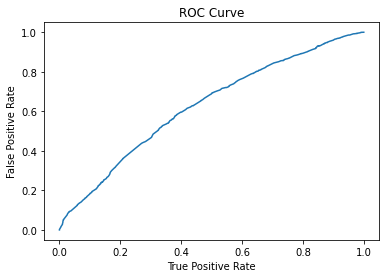

Training set areaUnderROC: 0.626287871641873


In [171]:
import matplotlib.pyplot as plt
import seaborn as sns

trainingSummary = rfModel.summary
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

### Evaluate our Random Forest Classifier

In [200]:
accuracy = evaluator.evaluate(predictions)
print("Accuracy = %s" % (accuracy))
print("Test Error = %s" % (1.0 - accuracy))


Accuracy = 0.519292653672366
Test Error = 0.480707346327634
